# Polynomial Regression, the Bias-Variance Dilemma, and Learning Curves

BUSMGT 7247

In [1]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt

np.random.seed(100)

## Polynomial Regression

In [2]:
# Generate data according to the function
# y = 0.5x^2 + x + 2 + noise,
# where noise is standard normal

m = 100  # Count of instances

X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

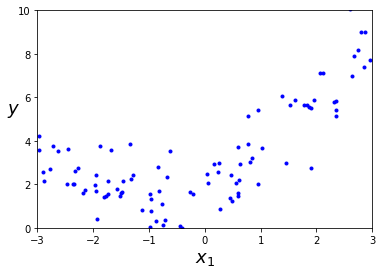

In [3]:
# Plot the generated data
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [4]:
# Use sklearn to preprocess the polynomial feature, x, with degree 2
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

print(X[0])
print(X_poly[0])

[0.26042965]
[0.26042965 0.0678236 ]


In [5]:
# Fit the polynomial regression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.84320636]), array([[0.95406518, 0.50130709]]))

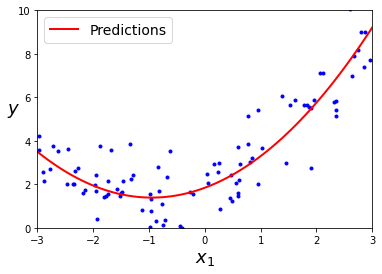

In [6]:
# Plot the model
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

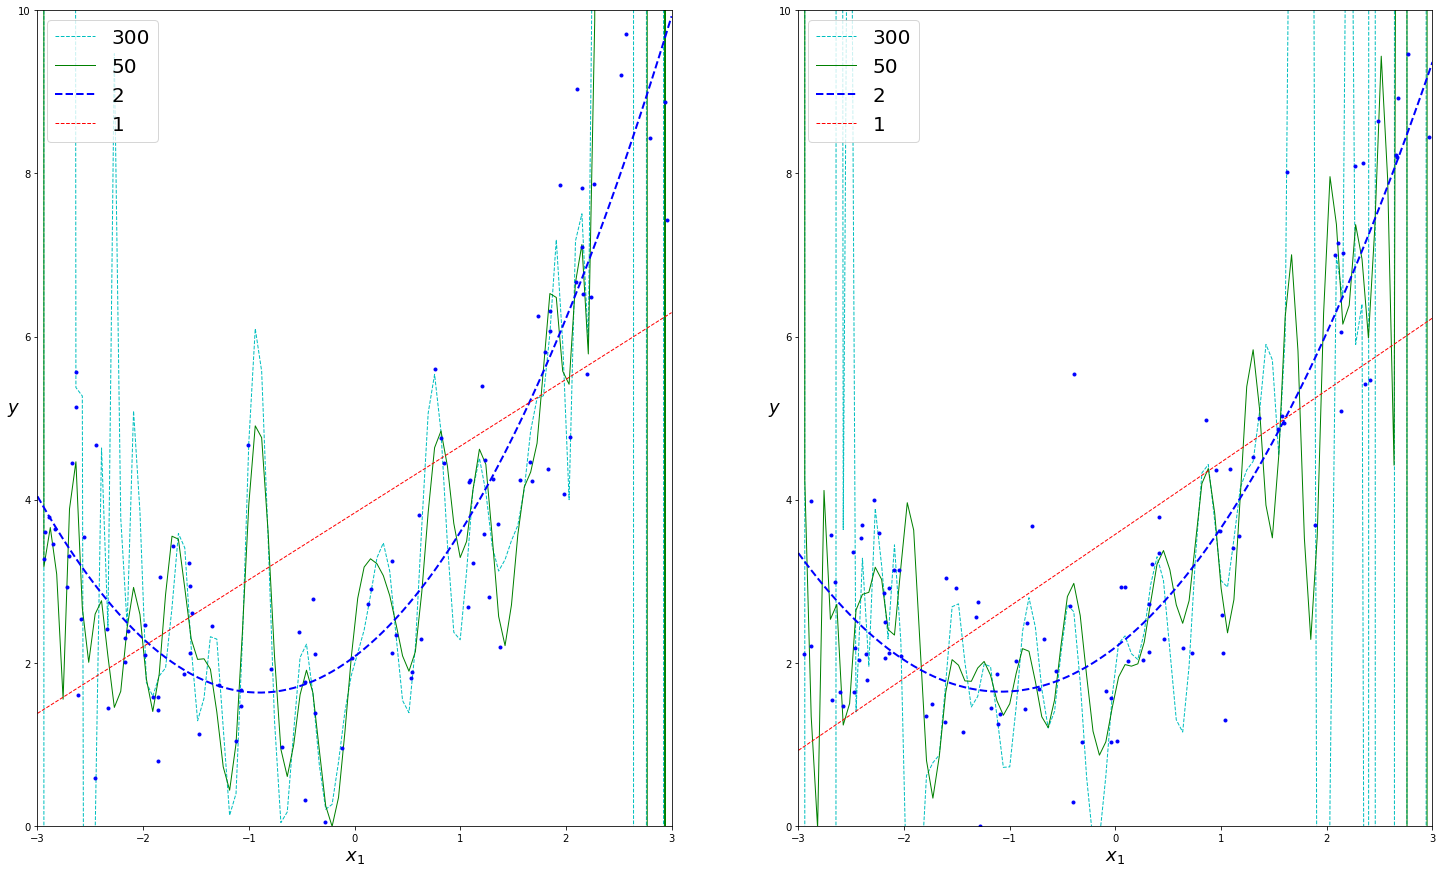

In [7]:
# Fit models with higher degree polynomials
combos = (('c--', 1, 300),
          ('g-', 1, 50),          
          ('b--', 2, 2),
          ('r--', 1, 1))

fig, ax = plt.subplots(1, 2, figsize=(25, 15))

for i in (0, 1):
    plt.axes(ax[i])
    
    X = 6 * np.random.rand(m, 1) - 3
    y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

    for style, width, degree in combos:
        polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
        std_scaler = StandardScaler()
        lin_reg = LinearRegression()
        polynomial_regression = Pipeline([
                ('poly_features', polybig_features),
                ('std_scaler', std_scaler),
                ('lin_reg', lin_reg),
            ])
        polynomial_regression.fit(X, y)
        y_newbig = polynomial_regression.predict(X_new)
        plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=20)
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$y$", rotation=0, fontsize=18)
    plt.axis([-3, 3, 0, 10])

plt.show()

## Learning Curves

In [8]:
# Utility function that splits data into training and testing,
# fits a model on progressively larger portions of the training data,
# evaluates using the test data, and plots the results
def plot_learning_curves(model, X, y, test_size):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

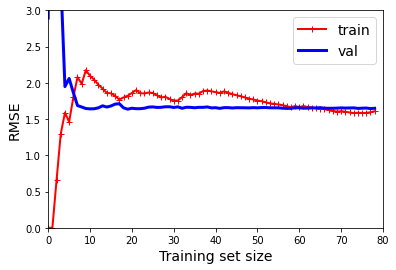

In [9]:
# Plot learning curves for a linear model without polynomial terms
# This model often underfits the data
test_size = 0.2
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y, test_size)
plt.axis([0, (1 - test_size)*m, 0, 3])
plt.show()            

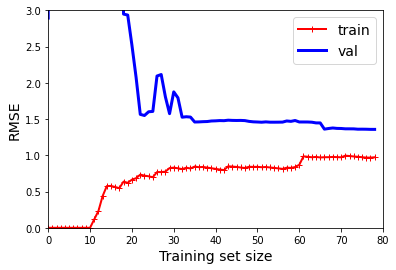

In [10]:
# Plot learning curves for a linear model with 10-degree polynomial terms
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y, test_size)
plt.axis([0, (1 - test_size)*m, 0, 3])
plt.show()

(0.0, 80.0, 0.0, 10.0)

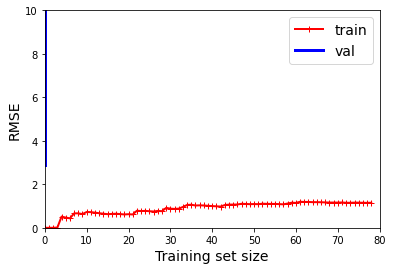

In [11]:
# Plot learning curves for a linear model with 50-degree polynomial terms
# This model often overfits the data
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=50, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y, test_size)
plt.axis([0, (1-test_size)*m, 0, 10]) 


## Regularization: Ridge Regression

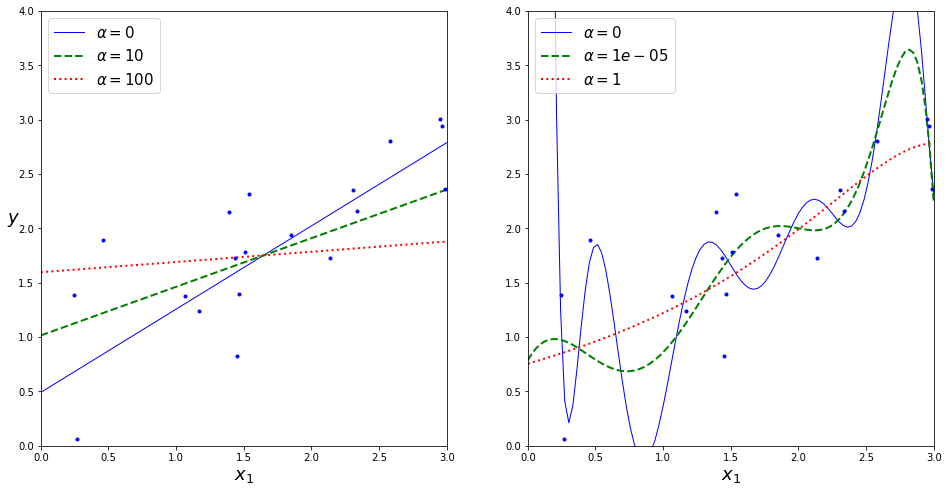

In [12]:
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(16,8))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()